2/24/24

This Notebook uses a lot of code from calcSimSystamatics (same directory), but compares a simulation and measurement from a monopole drive

- VNA is calibrated at end of chode cable. IE chode cable is calibrated out and refrence plane at at the bicon's port
- port 1 is bicon, 2 is monopole (both simulation and measurement). This was flipped for a sigle lab book entry on 2/23/24, but is now consistant
- data and calibration are saved in this directory. There are some notes in google doc lab book on 2_24_24


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import linregress

%matplotlib widget
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
#plt.style.use('dark_background')

# Plotting format for thesis
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=16, labelsize=16)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=18)

In [2]:
#pack df of measured data (measured 2/23/23) from CSVs

# Directory containing the CSV files
data_dir_new = '/drBigBoy/darkRadio/comsolSimulations/run1A_simulation_10_3_23/monopoleDriveSimValidation/data_2_24_24/'

# List of file indices to ignore
bad_data_idx = []

# Columns to extract from the CSV
columns_to_extract = ['Frequency', 'S11_Magnitude', 'S11_Phase', 'S22_Magnitude', 'S22_Phase', 'S12_Magnitude', 'S12_Phase']

# Initialize an empty DataFrame to hold the data
df_meas = pd.DataFrame()

# List all files in the directory that match the pattern and are not in the bad data index
for filename in os.listdir(data_dir_new):
    if filename.startswith('sParamData_p') and filename.endswith('.csv'):
        # Extract index from the filename and check if it's not in the bad data list
        file_idx = int(filename.split('p')[-1].split('.')[0])  # Extract the number after 'p'
        if file_idx not in bad_data_idx:
            # Construct full file path
            file_path = os.path.join(data_dir_new, filename)
            # Read the CSV file
            temp_df = pd.read_csv(file_path, usecols=columns_to_extract)
            # Add the index column
            temp_df['Index'] = file_idx
            # Append to the main DataFrame
            df_meas = pd.concat([df_meas, temp_df], ignore_index=True)

#VNA has glitch at 62.00MHz. Replace it with average of two adjacent bins
# Filter rows for the frequencies 61928888 and 62071111 across all indexes
adjacent_freqs_df = df_meas[df_meas['Frequency'].isin([61928888, 62071111])]

# Calculate the average for each S parameter for these frequencies by Index
avg_s_params = adjacent_freqs_df.groupby('Index').mean().drop(columns=['Frequency'])

# Replace the S parameters for frequency 62000000 Hz with the calculated averages
for idx, row in avg_s_params.iterrows():
    df_meas.loc[(df_meas['Frequency'] == 62000000) & (df_meas['Index'] == idx), ['S11_Magnitude', 'S11_Phase', 'S12_Magnitude', 'S12_Phase', 'S22_Magnitude', 'S22_Phase']] = row.values


df_meas['S11_Magnitude_Linear'] = 10 ** (df_meas['S11_Magnitude'] / 20.0)
df_meas['S22_Magnitude_Linear'] = 10 ** (df_meas['S22_Magnitude'] / 20.0)
df_meas['S12_Magnitude_Linear'] = 10 ** (df_meas['S12_Magnitude'] / 20.0)

print("unique sorted position indicies: ",np.sort(df_meas['Index'].unique()))

# Now combined_df contains all the data from the CSV files excluding the bad indices
df_meas.head()  # Show the first few rows of the DataFrame


unique sorted position indicies:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


,Frequency,S11_Magnitude,S11_Phase,S12_Magnitude,S12_Phase,S22_Magnitude,S22_Phase,Index,S11_Magnitude_Linear,S22_Magnitude_Linear,S12_Magnitude_Linear
0,30000000,-0.618858,-111.386332,-62.954829,-98.668651,0.078723,-8.863799,8,0.931230,1.009104,0.000712
1,30071111,-0.550007,-112.021716,-76.029575,47.294815,0.036788,-8.786781,8,0.938641,1.004244,0.000158
2,30142222,-0.545370,-112.748676,-76.620454,48.545765,0.036914,-8.800341,8,0.939143,1.004259,0.000148
3,30213333,-0.540811,-113.470659,-76.205563,38.262459,0.036941,-8.806801,8,0.939636,1.004262,0.000155
4,30284444,-0.539380,-114.201313,-77.099415,52.980421,0.037063,-8.819466,8,0.939790,1.004276,0.000140


In [3]:
###############################################
#  pack DF of comsol data  ####################
###############################################

import os
from os import listdir
from os.path import isfile, join
import fnmatch
import re
directory   = './comsolData_gitignore/40_310MHz_500Q_moveAnt_9pos_3wallDrive_steelWalls_2_25_24/' #include trailing `/`

'''
Open and process comsol data files. Save to one large dataframe. 

DF columns:
positionIdx, freq, Ex_near, Ey_n, Ez_n, Enorm_n, Ex_all, Ey_a, Ez_a, Enorm_a, LPV 

Rows:
frequency

shape = (postions * frequency steps) x (11)
size = (1 +(10*4))bytes * nPostions * nFrequencies
18 postions, 1000 frequencies size = 0.73MB

Also save text file with look up table of 
postionIdx, X, Y, Z, Alpha, Beta, Gamma
'''

def convert_to_complex(s):
    return complex(s.replace('i', 'j'))


#get list of files in directory
files = [f for f in listdir(directory) if isfile(join(directory, f))]
assert files != [], f"empty list in {directory}"

#generate list of file names that match pattern strings
#assumes order of "near, all, lpv"!!!!
pattern_strs    = ['.*allE.*all18.*', '.*s12_18*.*', '.*s22_18pos*.*'] 
fileNames       = []
for pattern_str in pattern_strs:
    pattern     = re.compile(pattern_str, re.IGNORECASE)
    fileName    = [s for s in files if pattern.match(s)]
    try: 
        assert len(fileName) == 1
    except:
        print(f"No files or multple files match ' {pattern_str}. Check directory {directory}\n")
        continue
    fileNames.append(fileName[0])
assert len(fileNames) != 0, f'no files in {directory} match'

print(f'{len(fileNames)} File names will be used to create DF:')
for file in fileNames: print(file)  

dfOut = pd.DataFrame()

#perform fuckary to fix comsol's stupid text file output. 
#modify 4th row of text (column names) to have white space delimiter and split on whitespace
for fileIdx, fileName in enumerate(fileNames):
    with open(directory + fileName, 'r') as f:
        data = f.readlines()
    data[4] = data[4].replace('%','')
    data[4] = data[4].replace(' (cm)','(cm)')
    data[4] = data[4].replace(' (MHz)','(MHz)')
    data[4] = data[4].replace('abs(emw.Ex) (V/m), Point: (', ' Ex_atPoint(') #header must start with 'E<i>' 
    data[4] = data[4].replace('abs(emw.Ey) (V/m), Point: (', ' Ey_atPoint(') #on these 3 lines.
    data[4] = data[4].replace('abs(emw.Ez) (V/m), Point: (', ' Ez_atPoint(')
    data[4] = data[4].replace('abs(emw.normE) (V/m), Point: (', ' Enorm_atPoint(')
    data[4] = data[4].replace(', ',',')
    data[4] = data[4].replace('(V)','')
    data[4] = data[4].replace('abs(emw.S12) (1)','S12')
    data[4] = data[4].replace('abs(emw.S22) (1)','S22')
    
    header = data[4].split()
    print()
    print('Working on: ', fileName)
    #print(header)
    # read the file and skip the first 5 rows, get column names from header defined above
    df = pd.read_csv(directory + fileName, delim_whitespace=True, skiprows=5, header=None)
    df.columns = header

    #overwrite position and frequency columns to make life easy
    positionCol = df[[col for col in df if col.startswith('positionIdx')]]
    #print(positionCol)
    dfOut['positionIdx'] = positionCol.astype(np.int16)
    freqCol = df[[col for col in df if col.startswith('freq')]]
    dfOut['freq(MHz)'] = freqCol.astype(np.float32)

    ############## Data extraction. Modify here to add new files ##############

    #extract field from non LPV files
    #if ('LPV' not in fileName) and ('lpv' not in fileName) and ('Lpv' not in fileName):
    if ('allE_' in fileName):
        #print(fileName)
        fieldCompStrs   = ['Ex', 'Ey', 'Ez', 'Enorm']
        if ('near' in fileName) or ('Near' in fileName):
            fieldLoc = '_near'
        else:
            fieldLoc = '_all'
        for fieldCompStr in fieldCompStrs:
            filter_col = [col for col in df if col.startswith(fieldCompStr)]
            try:
                assert filter_col != []
            except:
                print(f'no data for {fieldCompStr} in {fileName}')
            dfOut[fieldCompStr+fieldLoc] = df[filter_col].mean(axis=1).astype(np.float32)
    #else extract LPV from LPV file
    if ('LPV' in fileName) or ('lpv' in fileName) or ('Lpv' in fileName):
        filter_col = [col for col in df if col.startswith('abs(emw.Vport')]
        dfOut['LPV'] = df[filter_col].astype(np.float32)
    if ('s12' in fileName):
        filter_col = [col for col in df if col.startswith('S12')]
        dfOut['s12'] = df[filter_col].astype(np.float32)
    if ('s22' in fileName):
        filter_col = [col for col in df if col.startswith('S22')]
        dfOut['s22'] = df[filter_col].astype(np.float32)
def dBs11ToLin(dB):
    return 10**(dB/20)
#dfOut['s11'] = dfOut['s11'].transform(dBs11ToLin)
dfOut
#dfOut.to_pickle(directory+'dataDf.npy')

3 File names will be used to create DF:
allE_all18AntPos_3_1_24_64pos.txt
s12_18pos_3_1_24.txt
s22_18pos_3_1_24.txt

Working on:  allE_all18AntPos_3_1_24_64pos.txt

Working on:  s12_18pos_3_1_24.txt

Working on:  s22_18pos_3_1_24.txt


,positionIdx,freq(MHz),Ex_all,Ey_all,Ez_all,Enorm_all,s12,s22
0,0,40.000000,0.195592,0.409363,0.238936,0.535073,0.001578,0.999955
1,0,40.080002,0.195785,0.409533,0.239017,0.535349,0.001589,0.999954
2,0,40.160000,0.195978,0.409704,0.239099,0.535628,0.001600,0.999954
3,0,40.240002,0.196173,0.409875,0.239181,0.535907,0.001611,0.999954
4,0,40.320999,0.196371,0.410049,0.239265,0.536191,0.001623,0.999953
...,...,...,...,...,...,...,...,...
18463,17,307.612000,9.645697,2.319103,7.168962,13.046581,0.013868,0.987360
18464,17,308.227997,9.512001,2.515905,6.943558,12.554464,0.065075,0.986077
18465,17,308.843994,27.711271,7.537200,22.008179,38.476192,0.030202,0.907771
18466,17,309.462006,34.181454,19.290890,35.567093,57.836971,0.261081,0.748035


In [4]:
dfOut.positionIdx.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int16)

In [5]:
#load data from simpler simulation (no monopole, same everything else) 
# this is packed in ./moveAntvsModeStir/analysis_moveAntvsModeStir.ipynb
directory   = '../moveAnt_vs_modeStir/data_gitignore/40_310MHz_500Q_moveAnt_18pos_3wallDrive_steelWalls_10_8_23/' #include trailing `/`


df_comsol_onlyBicon = np.load(directory + 'dataDf.npy', allow_pickle=True)
df_comsol_onlyBicon

,positionIdx,freq(MHz),Ex_near,Ey_near,Ez_near,Enorm_near,Ex_all,Ey_all,Ez_all,Enorm_all,LPV,s11
0,0,40.000000,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999970
1,0,40.080002,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999970
2,0,40.160000,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999969
3,0,40.240002,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999969
4,0,40.320999,0.622485,1.069996,0.751014,1.495096,0.648414,0.677096,0.646404,1.195279,0.153183,0.999968
...,...,...,...,...,...,...,...,...,...,...,...,...
18463,17,307.612000,39.170479,12.002538,32.207817,55.924423,31.140749,13.869156,35.924980,52.330589,4.309466,0.698746
18464,17,308.227997,23.809851,19.963230,18.973083,39.374134,18.308559,15.750480,21.750729,36.250748,1.715535,0.586095
18465,17,308.843994,17.787285,13.663861,22.248446,33.732182,21.868002,7.615380,25.229118,35.925175,2.074518,0.622723
18466,17,309.462006,13.672132,13.680718,15.211812,25.982218,15.533454,7.776422,15.336432,25.544699,0.778493,0.309704


In [16]:
plt.close('all')

measured_s11_mean_all   = df_meas.groupby('Frequency')['S11_Magnitude_Linear'].mean()
measured_s22_mean_all   = df_meas.groupby('Frequency')['S22_Magnitude_Linear'].mean()
measured_s12_mean_all   = df_meas.groupby('Frequency')['S12_Magnitude_Linear'].mean()

measured_s11_pos0   = df_meas[df_meas['Index'] == 0].groupby('Frequency')['S11_Magnitude_Linear'].mean()
measured_s22_pos0   = df_meas[df_meas['Index'] == 0].groupby('Frequency')['S22_Magnitude_Linear'].mean()
measured_s12_pos0   = df_meas[df_meas['Index'] == 0].groupby('Frequency')['S12_Magnitude_Linear'].mean()

measured_s11_pos1   = df_meas[df_meas['Index'] == 1].groupby('Frequency')['S11_Magnitude_Linear'].mean()
measured_s22_pos1   = df_meas[df_meas['Index'] == 1].groupby('Frequency')['S22_Magnitude_Linear'].mean()
measured_s12_pos1   = df_meas[df_meas['Index'] == 1].groupby('Frequency')['S12_Magnitude_Linear'].mean()

measured_s11_pos2   = df_meas[df_meas['Index'] == 2].groupby('Frequency')['S11_Magnitude_Linear'].mean()
measured_s22_pos2   = df_meas[df_meas['Index'] == 2].groupby('Frequency')['S22_Magnitude_Linear'].mean()
measured_s12_pos2   = df_meas[df_meas['Index'] == 2].groupby('Frequency')['S12_Magnitude_Linear'].mean()

measured_s11_pos3   = df_meas[df_meas['Index'] == 3].groupby('Frequency')['S11_Magnitude_Linear'].mean()
measured_s22_pos3   = df_meas[df_meas['Index'] == 3].groupby('Frequency')['S22_Magnitude_Linear'].mean()
measured_s12_pos3   = df_meas[df_meas['Index'] == 3].groupby('Frequency')['S12_Magnitude_Linear'].mean()

measured_s11_pos4   = df_meas[df_meas['Index'] == 4].groupby('Frequency')['S11_Magnitude_Linear'].mean()
measured_s22_pos4   = df_meas[df_meas['Index'] == 4].groupby('Frequency')['S22_Magnitude_Linear'].mean()
measured_s12_pos4   = df_meas[df_meas['Index'] == 4].groupby('Frequency')['S12_Magnitude_Linear'].mean()


measured_s12_avg   = df_meas[df_meas['Index'].isin([0,1,2,3,4,5,6,7])].groupby('Frequency')['S12_Magnitude_Linear'].mean()
measured_s12_avg2   = df_meas[df_meas['Index'].isin([8,9,10,11,12,13,14,15,16])].groupby('Frequency')['S12_Magnitude_Linear'].mean()


measured_freqs      = df_meas['Frequency'].unique()/1e6
#simulated_mean_all  = df_comsol.groupby('freq(MHz)')['s11'].mean()
#simulated_freqs     =df_comsol['freq(MHz)'].unique()

#filtered_df = df_comsol[df_comsol['positionIdx'].isin([0,2,4,6,8,10,12,14,16])]
#simulated_mean_9pos = filtered_df.groupby('freq(MHz)')['s11'].mean()

# Interpolate the simulated average onto the measured frequencies
#measured_interpolated_all = np.interp(simulated_freqs, measured_freqs, measured_mean_all, )

if 0:
    plt.figure()
    plt.title("Average of all positions (dB)")
    plt.plot(measured_freqs, 20*np.log10(measured_s11_mean_all), label = 'meas S11')
    plt.plot(measured_freqs, 20*np.log10(measured_s22_mean_all), label = 'meas S22')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('S parameter (dB)')
    plt.legend()

    plt.figure()
    plt.title("Average of all positions (Linear)")
    plt.plot(measured_freqs, measured_s11_mean_all, label = 'meas S11')
    plt.plot(measured_freqs, measured_s22_mean_all, label = 'meas S22')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('S parameter (Linear)')
    plt.legend()

    plt.figure()
    plt.title("S12, Average of all positions (dB)")
    plt.plot(measured_freqs, 20*np.log10(measured_s12_mean_all), label = 'meas S12')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('S12 (dB)')
    plt.legend()

    plt.figure()
    plt.title("S11 (dB) Avg All vs. Single Pos")
    plt.plot(measured_freqs, 20*np.log10(measured_s11_pos0), label = 'Signle pos')
    plt.plot(measured_freqs, 20*np.log10(measured_s11_mean_all), label = 'Avg all')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('S11 (dB)')
    plt.legend()

    plt.figure()
    plt.title("S22 (dB) Avg All vs. Single Pos")
    plt.plot(measured_freqs, 20*np.log10(measured_s22_pos0), label = 'Signle pos')
    plt.plot(measured_freqs, 20*np.log10(measured_s22_mean_all), label = 'Avg all')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('S11 (dB)')
    plt.legend()



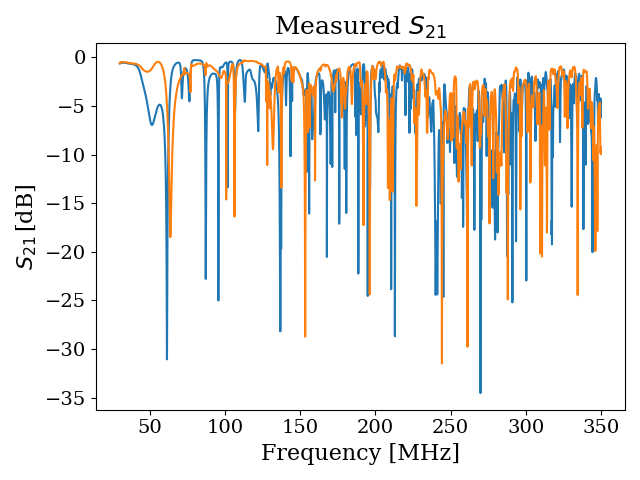

In [23]:
plt.figure()
plt.title(r"Measured $S_{21}$", fontsize = 18)
#plt.plot(measured_freqs, 20*np.log10(measured_s11_pos0), label = 'Position 0')
plt.plot(measured_freqs, 20*np.log10(measured_s11_pos1), label = 'Position 1')
#plt.plot(measured_freqs, 20*np.log10(measured_s11_pos2), label = 'Position 2')
#plt.plot(measured_freqs, 20*np.log10(measured_s11_pos3), label = 'Position 3')
plt.plot(measured_freqs, 20*np.log10(measured_s11_pos4), label = 'Position 4')
#plt.plot(measured_freqs, 20*np.log10(measured_s12_avg), label = 'Average (8)')
#plt.plot(measured_freqs, 20*np.log10(measured_s12_avg2), label = 'Average (Different 8)')
#plt.plot(measured_freqs, 20*np.log10(measured_s12_mean_all), label = 'Avg all')
plt.xlabel('Frequency [MHz]', fontsize = 16)
plt.ylabel(r'$S_{21}\,$[dB]', fontsize = 16)
#plt.xticks(fontsize = 14)
#plt.xticks(fontsize = 14);
plt.tight_layout()
#plt.ylim(-65,0)
#plt.legend(fontsize = 16)

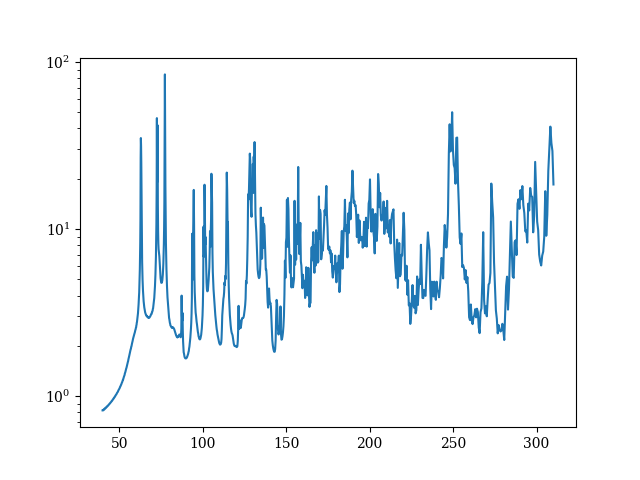

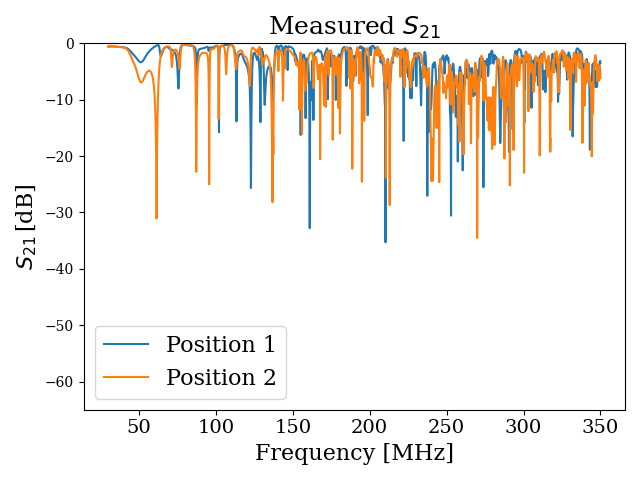

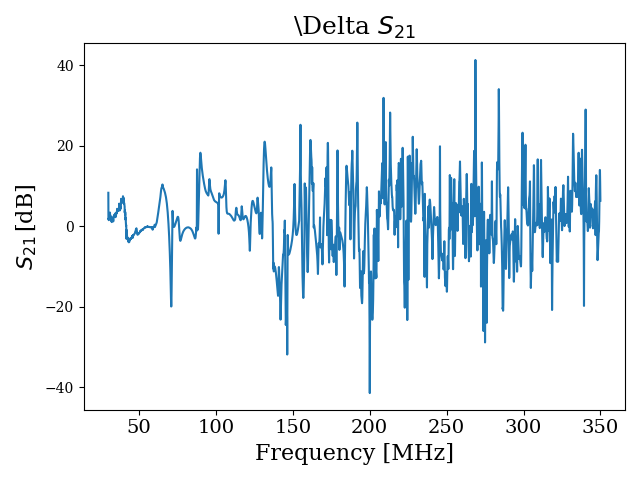

In [11]:
plt.close('all')
plt.figure()
plt.semilogy()
plt.plot(df_comsol_onlyBicon.groupby('freq(MHz)').mean()['Enorm_all']*2/3)

plt.figure()
plt.title(r"Measured $S_{21}$", fontsize = 18)
plt.plot(measured_freqs, 20*np.log10(measured_s12_pos0), label = 'Position 1')
plt.plot(measured_freqs, 20*np.log10(measured_s12_avg), label = 'Average (8)')
#plt.plot(measured_freqs, 20*np.log10(measured_s12_avg2), label = 'Average (Different 8)')
#plt.plot(measured_freqs, 20*np.log10(measured_s12_mean_all), label = 'Avg all')
plt.xlabel('Frequency [MHz]', fontsize = 16)
plt.ylabel(r'$S_{21}\,$[dB]', fontsize = 16)
plt.xticks(fontsize = 14)
plt.xticks(fontsize = 14);
plt.tight_layout()
plt.ylim(-65,0)
plt.legend(fontsize = 16)

plt.figure()
plt.title(r"\Delta $S_{21}$", fontsize = 18)
plt.plot(measured_freqs, 20*np.log10(measured_s12_pos0)-20*np.log10(measured_s12_pos1), label = 'Signle pos')

#plt.plot(measured_freqs, 20*np.log10(measured_s12_mean_all), label = 'Avg all')
plt.xlabel('Frequency [MHz]', fontsize = 16)
plt.ylabel(r'$S_{21}\,$[dB]', fontsize = 16)
plt.xticks(fontsize = 14)
plt.xticks(fontsize = 14);
plt.tight_layout()

In [8]:
###bootstrap measured data

n_pos_avg = 9 #num antenna positions
s11_samples = []
    
plt.close('all')
#plt.figure()

for i in range(1000):
    # Randomly select 9 positions from measured and simulated datasets
    measured_positions = np.random.choice(df_meas['Index'].unique(), n_pos_avg, replace=True)
    #simulated_positions = np.random.choice(df_comsol['positionIdx'].unique(), n_pos_avg, replace=True)

    # Get all frequency points for the selected measured positions
    measured_sample = df_meas[df_meas['Index'].isin(measured_positions)]
    # Group by frequency and calculate mean S11_Magnitude for the measured data
    measured_mean = measured_sample.groupby('Frequency')['S12_Magnitude_Linear'].mean()

    s11_samples.append(measured_mean)

# Convert list of arrays into a 2D numpy array
s11_samples_array = (np.vstack(s11_samples))

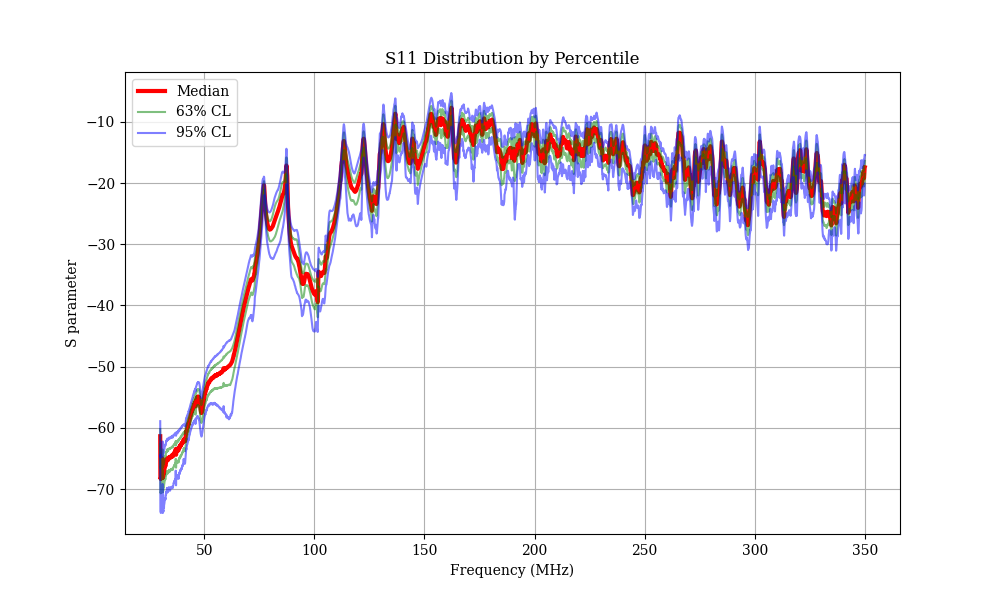

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


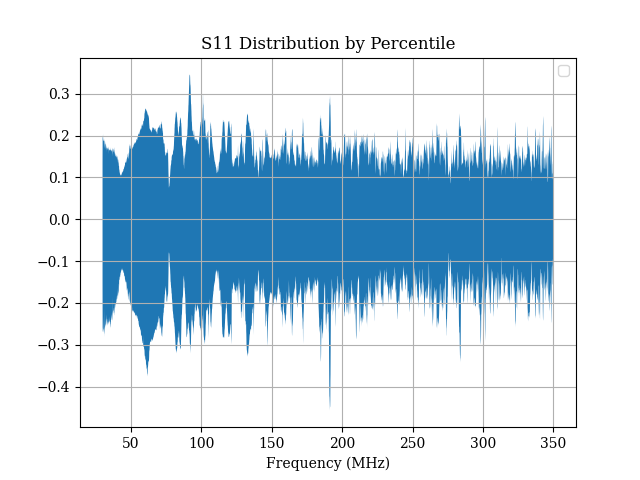

In [9]:
##### only plot median and 95% #####

# Define the list of percentiles to calculate


# Calculate median
median_s11 = np.percentile(s11_samples_array, 50 , axis=0)

# 63% s11
upper_63_s11 = np.percentile(s11_samples_array, (100-63)/2 , axis=0)
lower_63_s11 = np.percentile(s11_samples_array, 100-(100-63)/2 , axis=0)

# 95% s11
upper_95_s11 = np.percentile(s11_samples_array, (100-95)/2 , axis=0)
lower_95_s11 = np.percentile(s11_samples_array, 100-(100-95)/2 , axis=0)


plt.figure(figsize=(10, 6))

plt.xlabel('Frequency (MHz)')
plt.ylabel('S parameter')
plt.title('S11 Distribution by Percentile')
plt.plot(measured_freqs, 20*np.log10(median_s11), 'r', linewidth = 3, label = 'Median')
plt.plot(measured_freqs, 20*np.log10(upper_63_s11), 'g', label = '63% CL', alpha = .5)
plt.plot(measured_freqs, 20*np.log10(lower_63_s11), 'g', alpha = .5)
plt.plot(measured_freqs, 20*np.log10(upper_95_s11),'b', label = '95% CL', alpha = .5)
plt.plot(measured_freqs, 20*np.log10(lower_95_s11),'b', alpha = .5)
plt.legend()
plt.grid(True)
plt.show()


upper_fractional_uncertanty = (upper_63_s11-median_s11)/((upper_63_s11+median_s11)/2)
lower_fractional_uncertanty = (lower_63_s11-median_s11)/((lower_63_s11+median_s11)/2)

plt.figure()
plt.xlabel('Frequency (MHz)')
plt.ylabel('')
plt.title('S11 Distribution by Percentile')
plt.fill_between(measured_freqs, lower_fractional_uncertanty, upper_fractional_uncertanty)

plt.legend()
plt.grid(True)
plt.show()



In [10]:
###bootstrap measured and simulated data over different numbers of antenna positions
#sloppy: calls everything s11 but really its for s12 (sorry)

n_pos_avg_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23] #num antenna positions
s11_sim_freq_avg = []
s11_meas_freq_avg = []
    
plt.close('all')
#plt.figure()
for n_pos_avg in n_pos_avg_list:
    s11_meas_samples = []
    s11_sim_samples = []
    for i in range(100):
        # Randomly select 9 positions from measured and simulated datasets
        measured_positions = np.random.choice(df_meas['Index'].unique(), n_pos_avg, replace=True)
        simulated_positions = np.random.choice(dfOut['positionIdx'].unique(), n_pos_avg, replace=True)

        # Get all frequency points for the selected measured positions
        measured_sample = df_meas[df_meas['Index'].isin(measured_positions)]
        sim_sample = dfOut[dfOut['positionIdx'].isin(simulated_positions)]
        # Group by frequency and calculate mean S11_Magnitude for the measured data
        measured_mean = measured_sample.groupby('Frequency')['S12_Magnitude_Linear'].mean()
        sim_mean = sim_sample.groupby('freq(MHz)')['s12'].mean()

        s11_meas_samples.append(measured_mean)
        s11_sim_samples.append(sim_mean)

    # Convert list of arrays into a 2D numpy array
    s11_samples_array_meas = (np.vstack(s11_meas_samples))
    s11_samples_array_sim = (np.vstack(s11_sim_samples))

    # Calculate median percentiles meas
    median_s11 = np.percentile(s11_samples_array_meas, 50 , axis=0)
    upper_63_s11 = np.percentile(s11_samples_array_meas, (100-63)/2 , axis=0)
    lower_63_s11 = np.percentile(s11_samples_array_meas, 100-(100-63)/2 , axis=0)
    upper_fractional_uncertanty = (upper_63_s11-median_s11)/((upper_63_s11+median_s11)/2)
    lower_fractional_uncertanty = (lower_63_s11-median_s11)/((lower_63_s11+median_s11)/2)

    s11_meas_freq_avg.append(-1*((upper_fractional_uncertanty-lower_fractional_uncertanty)/2).mean())

    # Calculate median percentiles sim
    median_s11 = np.percentile(s11_samples_array_sim, 50 , axis=0)
    upper_63_s11 = np.percentile(s11_samples_array_sim, (100-63)/2 , axis=0)
    lower_63_s11 = np.percentile(s11_samples_array_sim, 100-(100-63)/2 , axis=0)
    upper_fractional_uncertanty = (upper_63_s11-median_s11)/((upper_63_s11+median_s11)/2)
    lower_fractional_uncertanty = (lower_63_s11-median_s11)/((lower_63_s11+median_s11)/2)

    s11_sim_freq_avg.append(-1*((upper_fractional_uncertanty-lower_fractional_uncertanty)/2).mean())

s11_meas_freq_avg = np.asarray(s11_meas_freq_avg)
s11_sim_freq_avg    = np.asarray(s11_sim_freq_avg);

/tmp/ipykernel_3643177/1500271770.py:39: RuntimeWarning: Mean of empty slice.
  s11_meas_freq_avg.append(-1*((upper_fractional_uncertanty-lower_fractional_uncertanty)/2).mean())
/home/dradmin/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_3643177/1500271770.py:48: RuntimeWarning: Mean of empty slice.
  s11_sim_freq_avg.append(-1*((upper_fractional_uncertanty-lower_fractional_uncertanty)/2).mean())


/tmp/ipykernel_2391414/1291929478.py:6: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(n_pos_avg_list, 1/np.sqrt(n_pos_avg_list), label = '1/sqrt N')
/tmp/ipykernel_2391414/1291929478.py:9: RuntimeWarning: divide by zero encountered in true_divide
  plt.scatter(n_pos_avg_list, 1/np.sqrt(n_pos_avg_list))


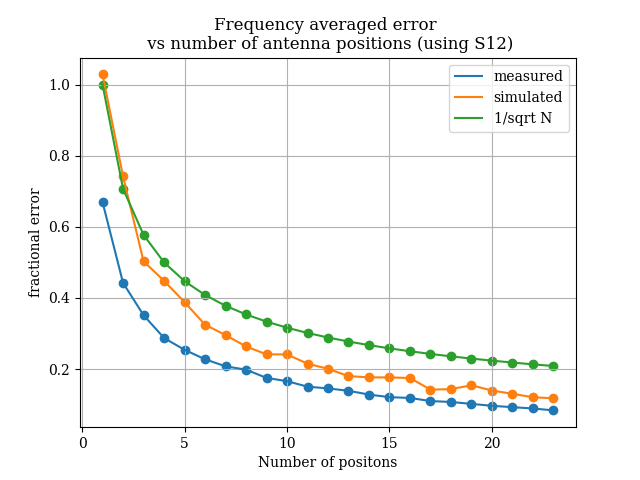

In [101]:
plt.close('all')
plt.figure()
plt.title('Frequency averaged error \n vs number of antenna positions (using S12)')
plt.plot((s11_meas_freq_avg), label = 'measured')
plt.plot((s11_sim_freq_avg), label = 'simulated')
plt.plot(n_pos_avg_list, 1/np.sqrt(n_pos_avg_list), label = '1/sqrt N')
plt.scatter(n_pos_avg_list, (s11_meas_freq_avg))
plt.scatter(n_pos_avg_list, (s11_sim_freq_avg))
plt.scatter(n_pos_avg_list, 1/np.sqrt(n_pos_avg_list))
plt.ylabel('fractional error')
plt.xlabel('Number of positons')
plt.plot()
plt.legend()
plt.grid()

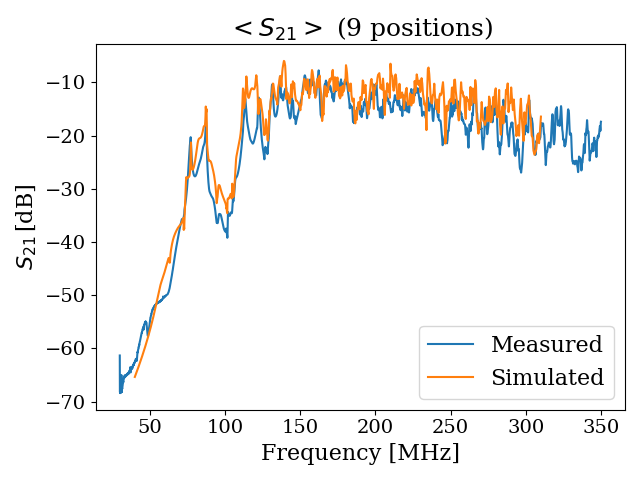

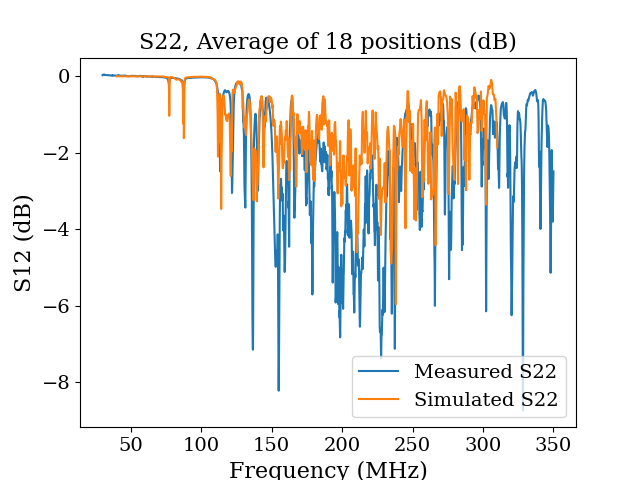

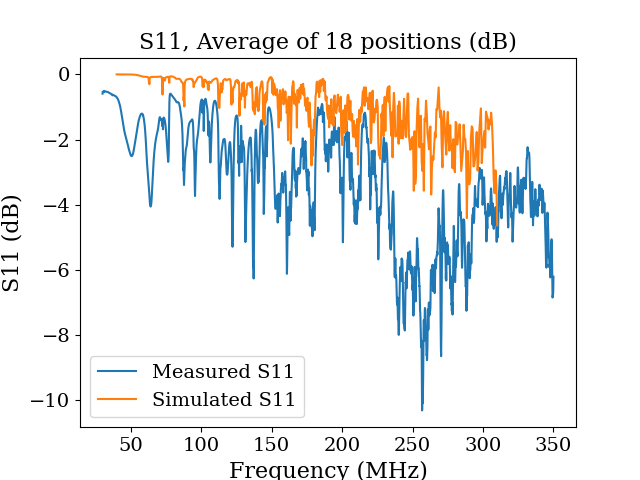

In [21]:
#compare measurement and simulation

plt.close('all')

filtered_df = df_meas[df_meas['Index'].between(0, 8)]
measured_s11_mean_9   = filtered_df.groupby('Frequency')['S11_Magnitude_Linear'].mean()
measured_s22_mean_9   = filtered_df.groupby('Frequency')['S22_Magnitude_Linear'].mean()
measured_s12_mean_9   = filtered_df.groupby('Frequency')['S12_Magnitude_Linear'].mean()

measured_freqs      = df_meas['Frequency'].unique()/1e6


sim_s12_allPos  = dfOut.groupby('freq(MHz)')['s12'].mean()
sim_s22_allPos  = dfOut.groupby('freq(MHz)')['s22'].mean()
sim_s11_allPos  = df_comsol_onlyBicon.groupby('freq(MHz)')['s11'].mean()
sim_freqs       = dfOut['freq(MHz)'].unique()

plt.figure()
plt.title(r"$<S_{21}>$ (9 positions)", fontsize = 18)
plt.plot(measured_freqs, 20*np.log10(measured_s12_mean_all), label = 'Measured')
plt.plot(sim_freqs, 20*np.log10(sim_s12_allPos), label = 'Simulated')
plt.xlabel('Frequency [MHz]', fontsize = 16)
plt.ylabel(r'$S_{21}\,$[dB]', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.legend(fontsize = 16)

plt.figure()
plt.title("S22, Average of 18 positions (dB)")
plt.plot(measured_freqs, 20*np.log10(measured_s22_mean_all), label = 'Measured S22')
plt.plot(sim_freqs, 20*np.log10(sim_s22_allPos), label = 'Simulated S22')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S12 (dB)')
plt.legend()

plt.figure()
plt.title("S11, Average of 18 positions (dB)")
plt.plot(measured_freqs, 20*np.log10(measured_s11_mean_all), label = 'Measured S11')
plt.plot(sim_freqs, 20*np.log10(sim_s11_allPos), label = 'Simulated S11')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S11 (dB)')
plt.legend()

140
3825


Text(0, 0.5, 'simulated s11')

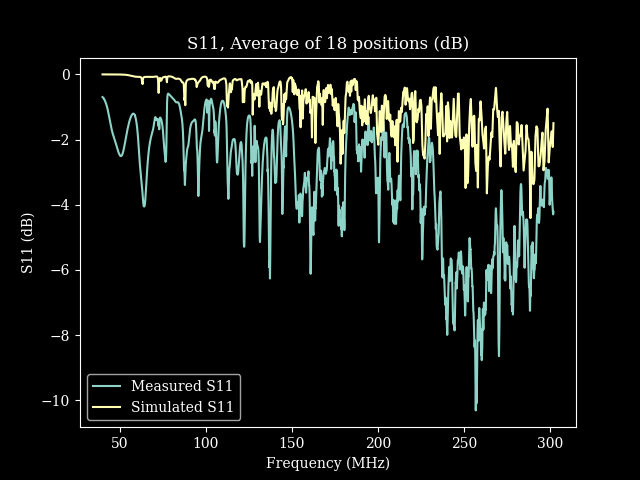

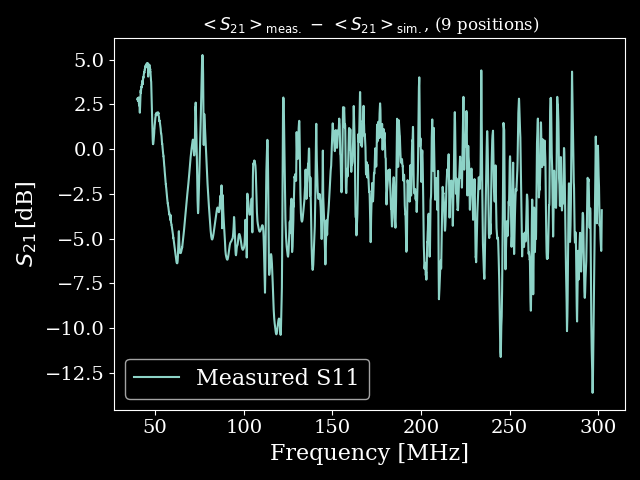

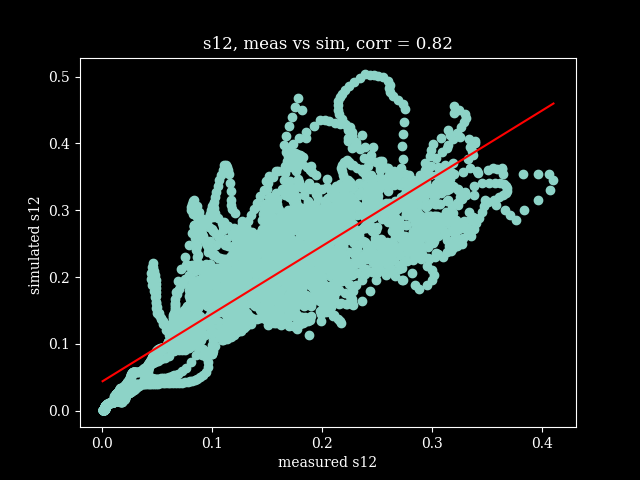

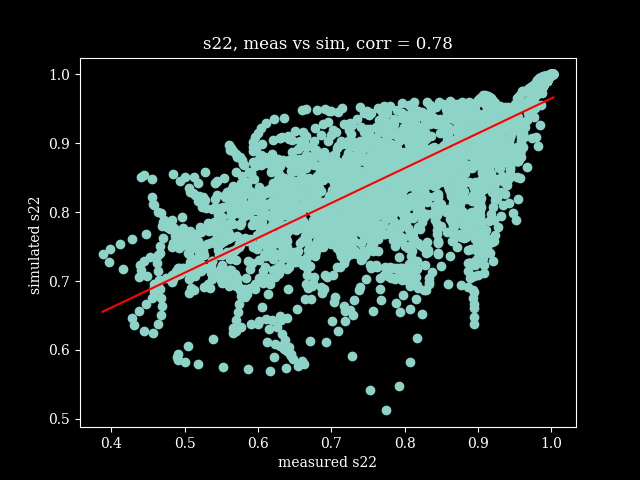

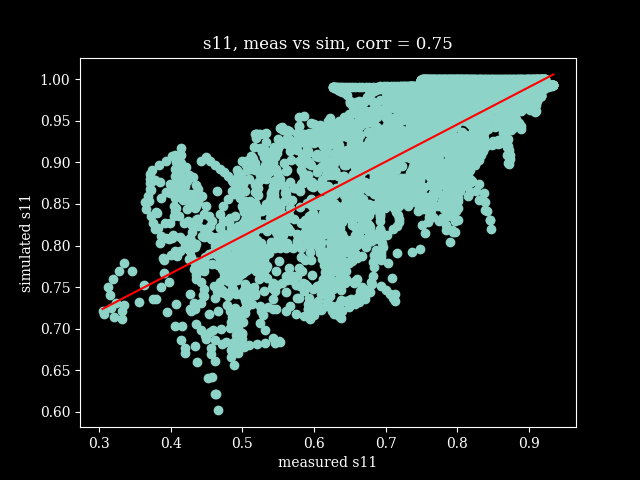

In [54]:
plt.close('all')

startIdx = int(len(measured_freqs) * (40-30)/(350-30))
stopIdx = int(len(measured_freqs) * .85)
print(startIdx)
print(stopIdx)

sim_s12_interp = np.interp(measured_freqs, sim_freqs, sim_s12_allPos)
sim_s22_interp = np.interp(measured_freqs, sim_freqs, sim_s22_allPos)
sim_s11_interp = np.interp(measured_freqs, sim_freqs, sim_s11_allPos)

plt.figure()
plt.title("S11, Average of 18 positions (dB)")
plt.plot(measured_freqs[startIdx:stopIdx], 20*np.log10(measured_s11_mean_all)[startIdx:stopIdx], label = 'Measured S11')
plt.plot(measured_freqs[startIdx:stopIdx], 20*np.log10(sim_s11_interp)[startIdx:stopIdx], label = 'Simulated S11')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S11 (dB)')
plt.legend()


plt.figure()
plt.title(r"$<S_{21}>_\mathrm{meas.}\,-\,<S_{21}>_\mathrm{sim.}$, (9 positions)")
plt.plot(measured_freqs[startIdx:stopIdx], (20*np.log10(measured_s12_mean_all)-20*np.log10(sim_s12_interp))[startIdx:stopIdx], label = 'Measured S11')
plt.xlabel('Frequency [MHz]', fontsize = 16)
plt.ylabel(r'$S_{21}\,$[dB]', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.legend(fontsize = 16)
#plt.legend()


###S12 corrolation
plt.figure()
corr = round(np.corrcoef(measured_s12_mean_9[startIdx:stopIdx],sim_s12_interp[startIdx:stopIdx])[0,1],2)
slope, intercept, r_value, p_value, std_err = linregress(measured_s12_mean_all[startIdx:stopIdx],sim_s12_interp[startIdx:stopIdx])
x = np.linspace(min(measured_s12_mean_9[startIdx:stopIdx]), max(measured_s12_mean_all[startIdx:stopIdx]), 100)
y = slope * x + intercept
plt.plot(x, y, color='red')  # Best fit line in red
plt.title(f's12, meas vs sim, corr = {corr}')
plt.scatter(measured_s12_mean_all[startIdx:stopIdx], sim_s12_interp[startIdx:stopIdx])
plt.xlabel('measured s12')
plt.ylabel('simulated s12 ')


###S22 corrolation
plt.figure()
corr = round(np.corrcoef(measured_s22_mean_all[startIdx:stopIdx],sim_s22_interp[startIdx:stopIdx])[0,1],2)
slope, intercept, r_value, p_value, std_err = linregress(measured_s22_mean_all[startIdx:stopIdx],sim_s22_interp[startIdx:stopIdx])
x = np.linspace(min(measured_s22_mean_all[startIdx:stopIdx]), max(measured_s22_mean_all[startIdx:stopIdx]), 100)
y = slope * x + intercept
plt.plot(x, y, color='red')  # Best fit line in red
plt.title(f's22, meas vs sim, corr = {corr}')
plt.scatter(measured_s22_mean_all[startIdx:stopIdx], sim_s22_interp[startIdx:stopIdx])
plt.xlabel('measured s22')
plt.ylabel('simulated s22 ')

###S11 corrolation
plt.figure()
corr = round(np.corrcoef(measured_s11_mean_all[startIdx:stopIdx],sim_s11_interp[startIdx:stopIdx])[0,1],2)
slope, intercept, r_value, p_value, std_err = linregress(measured_s11_mean_all[startIdx:stopIdx],sim_s11_interp[startIdx:stopIdx])
x = np.linspace(min(measured_s11_mean_all[startIdx:stopIdx]), max(measured_s11_mean_all[startIdx:stopIdx]), 100)
y = slope * x + intercept
plt.plot(x, y, color='red', label = 'best fit')  # Best fit line in red
plt.title(f's11, meas vs sim, corr = {corr}')
plt.scatter(measured_s11_mean_all[startIdx:stopIdx], sim_s11_interp[startIdx:stopIdx])
plt.xlabel('measured s11')
plt.ylabel('simulated s11')

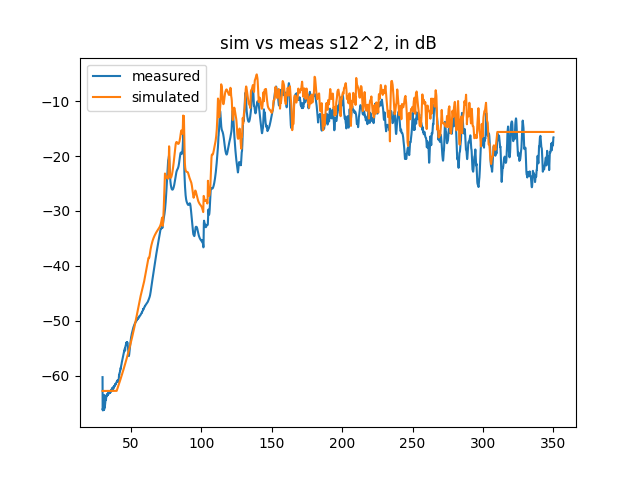

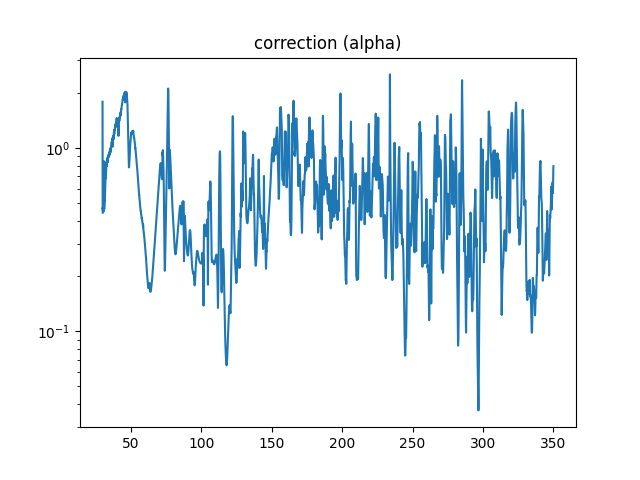

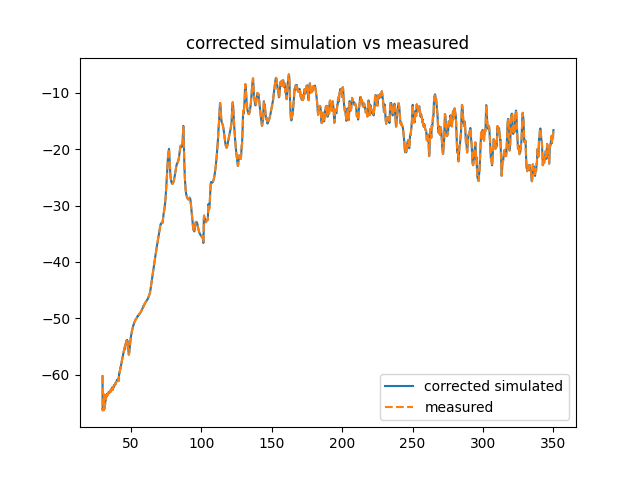

In [11]:
#define correction factor:
# alpha = <|S_12_meas|^2>/<|S_12,sim|^2>
import scipy.signal 

plt.close('all')

# List of real position index values
#index_values = [0, 2, 4, 6, 8, 10, 12, 14, 16]
#index_values = [0]
index_values = [0, 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
# Filter the DataFrame for rows where 'Index' is in the specified list of index values
filtered_df = df_meas[df_meas['Index'].isin(index_values)]
# Group by 'Frequency', square the 'S12_Magnitude_Linear' values, and then calculate the mean
realPosAvg_s12squared_measured = filtered_df.groupby('Frequency').apply(lambda x: (x['S12_Magnitude_Linear'] ** 2).mean())

# Filter the DataFrame for rows where 'Index' is in the specified list of index values
filtered_df = dfOut[dfOut['positionIdx'].isin(index_values)]
# Group by 'Frequency', square the 'S12_Magnitude_Linear' values, and then calculate the mean
realPosAvg_s12squared_sim = filtered_df.groupby('freq(MHz)').apply(lambda x: (x['s12'] ** 2).mean())

realPosAvg_s12squared_sim_interp = np.interp(measured_freqs, sim_freqs, realPosAvg_s12squared_sim)


if 1: #view the sim and measured sqaured averaged s12 curves
    plt.figure()
    plt.title('sim vs meas s12^2, in dB')
    plt.plot(measured_freqs, 10*np.log10(realPosAvg_s12squared_measured), label = 'measured')
    plt.plot(measured_freqs, 10*np.log10(realPosAvg_s12squared_sim_interp), label = 'simulated')
    plt.legend()
    plt.show()

#define alpha (correction factor)
alpha = realPosAvg_s12squared_measured/realPosAvg_s12squared_sim_interp

if 1: #view alpha
    plt.figure()
    plt.title('correction (alpha)')
    plt.plot(measured_freqs, (alpha))
    plt.semilogy()
    plt.show()

if 1: #view corrected simulation vs real simulation (should be the same)
    plt.figure()
    plt.title('corrected simulation vs measured')
    plt.plot(measured_freqs, 10*np.log10(alpha*realPosAvg_s12squared_sim_interp), label = 'corrected simulated')
    plt.plot(measured_freqs, 10*np.log10(realPosAvg_s12squared_measured), '--', label = 'measured')
    plt.legend()
    plt.show()

In [130]:
alpha.std()

0.3957334056363523

In [12]:
#check idxs that are used
listOfPosMeas   = df_meas['Index'].unique()
#listOfPosMeas   = [0,2,4,6,8,10,12,14,16]
listOfPosSim    = dfOut['positionIdx'].unique()
print(np.sort(listOfPosMeas))
print(np.sort(listOfPosSim))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [124]:
###bootstrap to compute uncertanty
plt.close('all')

n_pos_avg = 9 #num antenna positions
Delta = []

listOfPosMeas   = df_meas['Index'].unique()
#listOfPosMeas   = [0,2,4,6,8,10,12,14,16]
listOfPosSim    = dfOut['positionIdx'].unique()
#listOfPosSim    = [0,2,4,6,8,10,12,14,16]
#listOfPos   = [0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

realPosAvg_s12squared_sim_interp = np.interp(measured_freqs, sim_freqs, realPosAvg_s12squared_sim)

for i in range(1000):
    if i % 10 == 0:
        print(i)
    # Randomly select 9 positions from measured datasets
    randomIdxs = np.random.choice(listOfPosMeas, n_pos_avg, replace=True)
    
    ####testing
    #plot all positions that go into a single average
    if 0:
        plt.figure()
        plt.title('measured S12^2')
        for i in randomIdxs:
            plt.plot(df_meas[df_meas['Index'].isin([i])].groupby('Frequency').apply(lambda x: (x['S12_Magnitude_Linear'] ** 2).mean()), label = f'{i}')
        plt.plot(df_meas['Frequency'].unique(), s12squared_measured, label = 'avg', linewidth = 2)
        plt.legend()
        plt.semilogy()
    ###

    #compute <|S_12_meas|^2> over n_pos_avg bootstrap positions
    filtered_df = df_meas[df_meas['Index'].isin(randomIdxs)]
    s12squared_measured = filtered_df.groupby('Frequency').apply(lambda x: (x['S12_Magnitude_Linear'] ** 2).mean())

    randomIdxs = np.random.choice(listOfPosSim, n_pos_avg, replace=True)

    ####testing
    #plot all positions that go into a single average
    if 0:
        plt.figure()
        plt.title('simulated S12^2')
        for i in randomIdxs:
            plt.plot(dfOut[dfOut['positionIdx'].isin([i])].groupby('freq(MHz)').apply(lambda x: (x['s12'] ** 2).mean()), label = f'{i}')
        plt.plot(measured_freqs, s12squared_sim_interp, label = 'avg', linewidth = 2)
        plt.legend()
        plt.semilogy()
    ###

    #compute <|S_12_sim|^2> over n_pos_avg bootstrap positions
    filtered_df = dfOut[dfOut['positionIdx'].isin(randomIdxs)]
    s12squared_sim = filtered_df.groupby('freq(MHz)').apply(lambda x: (x['s12'] ** 2).mean())
    s12squared_sim_interp = np.interp(measured_freqs, sim_freqs, s12squared_sim)


    ###Testing
    #plot average s12 for single pass of bootstrap
    if 0:
        plt.figure()
        plt.title('<|S12|^2>')
        plt.plot(measured_freqs, s12squared_sim_interp, label = 'simulated')
        plt.plot(measured_freqs, s12squared_measured, label = 'measured')
        plt.legend(loc = 'upper right')
        plt.semilogy()
    ###

    Delta_i = (s12squared_measured -(alpha*s12squared_sim_interp))/((realPosAvg_s12squared_measured + (alpha* realPosAvg_s12squared_sim_interp))/2)
    #Delta_i = (s12squared_measured -(alpha*s12squared_sim_interp))/((s12squared_measured +(alpha *s12squared_sim_interp))/2)
    Delta.append(Delta_i)
        
    ###Testing
    #plot Delta_i for single pass of bootstrap
    if 0:
        plt.figure(10)
        plt.title('Delta')
        plt.plot(measured_freqs, Delta_i, label = i)
        plt.legend()
        #plt.semilogy()
    ###
    #Delta.append((s12squared_measured -(alpha*s12squared_sim_interp))/(s12squared_measured))
    #Delta.append((s12squared_measured -(alpha*s12squared_sim_interp)))

# Convert list of arrays into a 2D numpy array
Delta_samples_array = (np.vstack(Delta))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


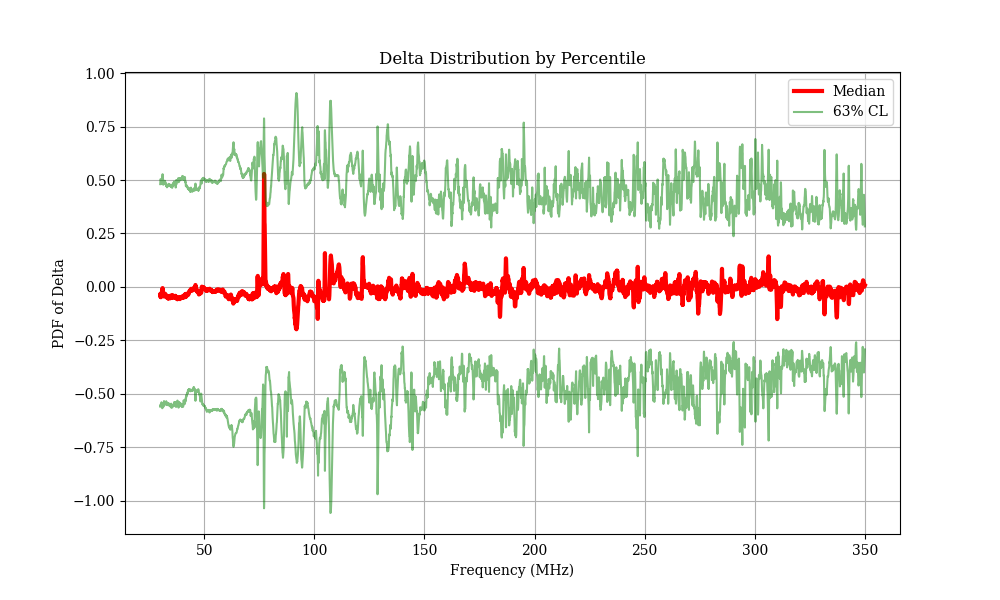

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


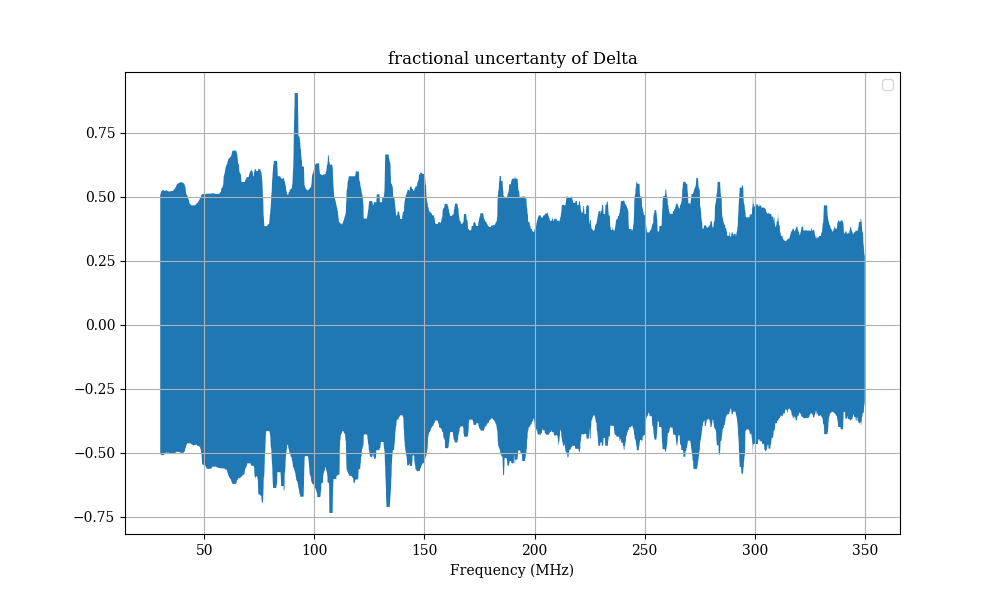

In [127]:
##### only plot median and 95% #####

# Define the list of percentiles to calculate


# Calculate median Delta
median_Delta = np.percentile(Delta_samples_array, 50 , axis=0)

# 63% s12
upper_63_Delta = np.percentile(Delta_samples_array, (100-63)/2 , axis=0)
lower_63_Delta = np.percentile(Delta_samples_array, 100-(100-63)/2 , axis=0)

# 95% s12
upper_95_Delta = np.percentile(Delta_samples_array, (100-95)/2 , axis=0)
lower_95_Delta = np.percentile(Delta_samples_array, 100-(100-95)/2 , axis=0)


plt.figure(figsize=(10, 6))

plt.xlabel('Frequency (MHz)')
plt.ylabel('PDF of Delta')
plt.title('Delta Distribution by Percentile')
plt.plot(measured_freqs, median_Delta, 'r', linewidth = 3, label = 'Median')
plt.plot(measured_freqs, upper_63_Delta, 'g', label = '63% CL', alpha = .5)
plt.plot(measured_freqs, lower_63_Delta, 'g', alpha = .5)
#plt.plot(measured_freqs, upper_95_Delta,'b', label = '95% CL', alpha = .5)
#plt.plot(measured_freqs, lower_95_Delta,'b', alpha = .5)
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
#upper_fractional_uncertanty = (upper_63_Delta-median_Delta)/median_Delta
#lower_fractional_uncertanty = (lower_63_Delta-median_Delta)/median_Delta

#upper_fractional_uncertanty = (upper_63_Delta-median_Delta)/((upper_63_Delta+median_Delta)/2)
#lower_fractional_uncertanty = (lower_63_Delta-median_Delta)/(((upper_63_Delta+median_Delta))/2)

upper_fractional_uncertanty = (upper_63_Delta-median_Delta)
lower_fractional_uncertanty = (lower_63_Delta-median_Delta)

#upper_fractional_uncertanty = (upper_63_Delta)
#lower_fractional_uncertanty = (lower_63_Delta)

upper_fractional_uncertanty = scipy.signal.medfilt(upper_fractional_uncertanty, 41)
lower_fractional_uncertanty = scipy.signal.medfilt(lower_fractional_uncertanty, 41)

plt.xlabel('Frequency (MHz)')
plt.ylabel('')
plt.title('fractional uncertanty of Delta')
plt.fill_between(measured_freqs,upper_fractional_uncertanty,lower_fractional_uncertanty)

plt.legend()
plt.grid(True)
plt.show()

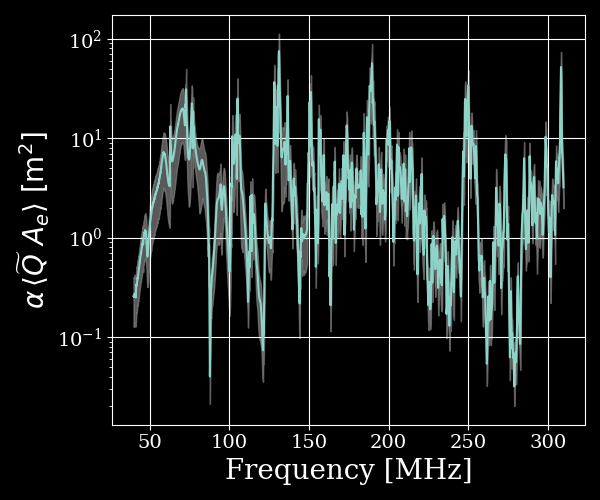

In [155]:
plt.close('all')
filtered_df = df_comsol_onlyBicon[df_comsol_onlyBicon['positionIdx'].isin([0,2,4,6,8,10,12,14,16])]
avgLPV = filtered_df.groupby('freq(MHz)')['LPV'].mean()
#avgLPV = df_comsol_onlyBicon.groupby('freq(MHz)')['LPV'].mean()

P_r = avgLPV**2/50 #watts

avgQ_Ae = P_r / ((2/np.sqrt(3))**2 / 377)
avgQ_Ae = np.interp(measured_freqs, sim_freqs, avgQ_Ae)

startIdx = 140
stopIdx= -565

plt.figure(figsize=(6, 5))
#plt.title('Aperture')
plt.plot(measured_freqs[startIdx:stopIdx], (alpha*avgQ_Ae)[startIdx:stopIdx])
plt.fill_between(measured_freqs[startIdx:stopIdx], 
    (alpha*avgQ_Ae*(1+upper_fractional_uncertanty))[startIdx:stopIdx], 
    (alpha*avgQ_Ae*(1+lower_fractional_uncertanty))[startIdx:stopIdx],
    alpha = .7, 
    color = 'gray' )
plt.ylabel(r'$\alpha \, \langle \widetilde{Q} \, \, A_e \rangle \, \, [\mathrm{m}^2]$', fontsize=20)
plt.xlabel('Frequency [MHz]', fontsize=20)
plt.tick_params('y',labelrotation=0,labelsize = 14)
plt.tick_params('x',labelrotation=0,labelsize = 14)
plt.semilogy()
plt.tight_layout()
plt.grid()

if 0:
    plt.figure()
    plt.title('sqrt Aperture')
    plt.plot(measured_freqs[startIdx:stopIdx], np.sqrt((alpha*avgQ_Ae)[startIdx:stopIdx]))
    plt.fill_between(measured_freqs[startIdx:stopIdx], 
        np.sqrt(alpha*avgQ_Ae*(1+upper_fractional_uncertanty))[startIdx:stopIdx], 
        np.sqrt(alpha*avgQ_Ae*(1+lower_fractional_uncertanty))[startIdx:stopIdx],
        alpha = .7, 
        color = 'orange' )
    plt.xlabel('Frequency - 240 MHz [kHz]', fontsize=20)
    plt.ylabel(r'$\mathrm{S}_{\mathbf{o}}$ [pW/$\Delta \nu_{\mathrm{RF}}$]', fontsize=20)
    plt.tick_params('y',labelrotation=0,labelsize = 14)
    plt.tick_params('x',labelrotation=0,labelsize = 14)
    plt.semilogy()
    plt.tight_layout()
    plt.grid()

#save aperture and uncertanty
#### WILL OVERWRITE ####
if 0:
    QAe         = np.stack(
        [
            measured_freqs,
            (alpha*avgQ_Ae),
            alpha*avgQ_Ae*(1+upper_fractional_uncertanty),
            alpha*avgQ_Ae*(1+lower_fractional_uncertanty)
        ]
    )
    plt.figure()
    plt.plot(QAe[0], QAe[1])
    plt.fill_between(QAe[0], QAe[2], QAe[3], color ='orange')
    plt.semilogy()
    #np.save('../../../daqAnalysisAndExperiments/run1p4/run1p4_analysis/computeLimit/data/QAe_avg_mSquared_FreqMHz_errorFromS12_3_18_24', QAe)


[]

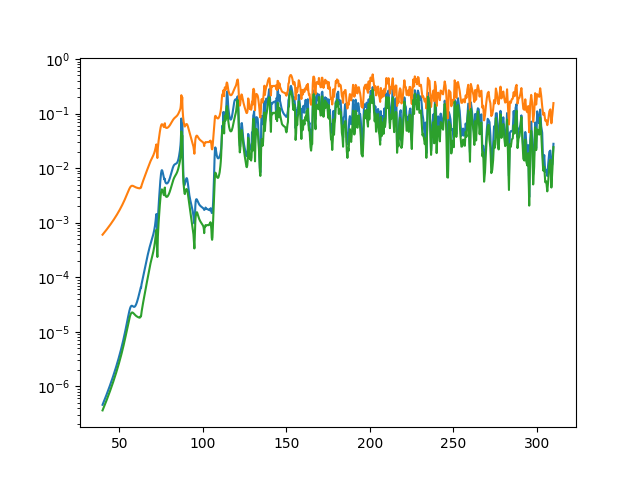

In [56]:
plt.close('all')
plt.figure()
filtered_df = dfOut[dfOut['positionIdx'].isin(randomIdxs)]
plt.plot(filtered_df.groupby('freq(MHz)').apply(lambda x: (x['s12'] ** 2).mean()))
plt.semilogy()

plt.plot(filtered_df.groupby('freq(MHz)').mean()['s12'])
plt.semilogy()

plt.plot((filtered_df.groupby('freq(MHz)').mean()['s12'])**2)
plt.semilogy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]

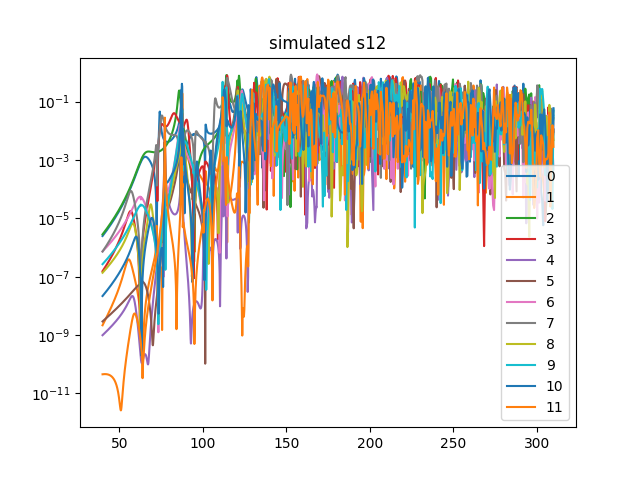

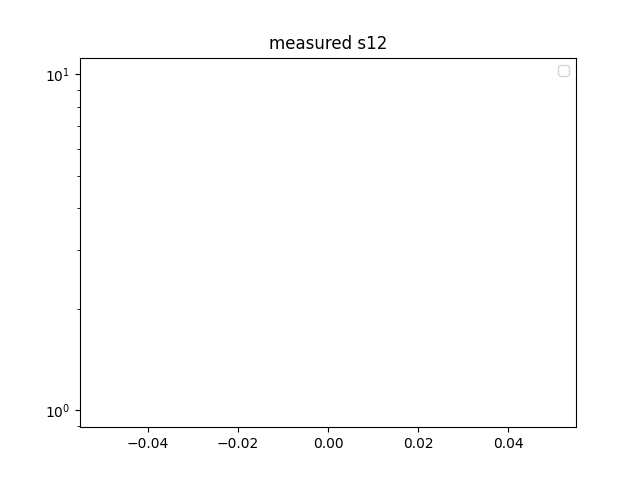

In [53]:
plt.close('all')
plt.figure()
plt.title('simulated s12')
for i in range(12):
    plt.plot(dfOut[dfOut['positionIdx'].isin([i])].groupby('freq(MHz)').apply(lambda x: (x['s12'] ** 2).mean()), label = f'{i}')
plt.legend()
plt.semilogy()

plt.figure()
plt.title('measured s12')
for i in range(0):
    filtered_df = df_meas[df_meas['Index'].isin([i])]
    s12squared_measured = filtered_df.groupby('Frequency').apply(lambda x: (x['S12_Magnitude_Linear'] ** 2).mean())
    plt.plot(s12squared_measured, label = f'{i}')
plt.legend()
plt.semilogy()

